In [1]:
# Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import impute
import scoring

In [2]:
# Load Raw Data

path_features = "./data/train_features.csv"
path_labels = "./data/train_labels.csv"

raw_data = pd.read_csv(path_features)
training_labels = pd.read_csv(path_labels)

#pd.options.display.max_columns = 200

In [3]:
# Initialize New DataFrame By Columns

raw_columns = list(raw_data.columns)
used_columns = raw_columns
not_used_columns = ['pid', 'Age', 'Time']

for name in not_used_columns:
    used_columns.remove(name)

columns_max = used_columns.copy()
for i, name in enumerate(columns_max):
    columns_max[i] = columns_max[i] + '_max'

columns_min = used_columns.copy()
for i, name in enumerate(columns_min):
    columns_min[i] = name + '_min'

columns_med = used_columns.copy()
for i, name in enumerate(columns_med):
    columns_med[i] = name + '_med'

features = ['pid', 'age'] + columns_min + columns_max + columns_med

feature_set = pd.DataFrame(columns=features)

ini_df = np.zeros((raw_data['pid'].nunique(), feature_set.shape[1]))
feature_set = feature_set.append(pd.DataFrame(ini_df, columns=feature_set.columns), ignore_index=True)

In [4]:
# Fill DataFrame by Grouped Patient Data

grouped_features = raw_data.groupby("pid")

index_var = 0
for name, data in grouped_features:

    feature_set.iloc[index_var,0] = name
    feature_set.iloc[index_var, 1] = data.iloc[0, 2]
    feature_set.iloc[index_var, 2:36] = grouped_features.get_group(name).min().iloc[3:]
    feature_set.iloc[index_var, 36:70] = grouped_features.get_group(name).max().iloc[3:]
    feature_set.iloc[index_var, 70:104] = grouped_features.get_group(name).median().iloc[3:]
    
    index_var = index_var + 1

In [5]:
# Impute Missing Values

full_feature_set, (single_imputers, multi_imputers) = impute.impute(feature_set, 0.0, 100)
np.savetxt("full_feature_set.csv", full_feature_set, delimiter=",")
#full_feature_set = pd.read_csv("./full_feature_set.csv", names=features)
#feature_set_array = np.array(full_feature_set)
df_full_feature_set = pd.DataFrame(full_feature_set, columns=features)

In [6]:
# Scaling of Training Data

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df_full_feature_set)
scaler.mean_
scaler.scale_
full_feature_set_scaled = scaler.transform(df_full_feature_set)

In [9]:
# Score Models On Dataset

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier

models = [LogisticRegressionCV(penalty='l2', max_iter=500), LogisticRegressionCV(penalty='l1', solver='saga', max_iter=500), AdaBoostClassifier(random_state=1)]

labels_task_one = training_labels.iloc[:,:11].sort_values('pid')
#models = [AdaBoostClassifier(random_state=1)]

#for i in range(1,11):

#test_scoreboard_ada = scoring.scoreboard(models, pd.DataFrame(full_feature_set, columns=features), labels_task_one.iloc[:,i], 0.8)
test_scoreboard_ada_scaled = scoring.scoreboard(models, pd.DataFrame(full_feature_set_scaled, columns=features), labels_task_one.iloc[:,1], 0.8)
print(f'scaled: {test_scoreboard_ada_scaled}')
#print(f'not scaled: {test_scoreboard_ada}')

/Users/joschkakayenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joschkakayenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

scaled: {LogisticRegressionCV(max_iter=500): (0.7888779203685423, 0.7841537246643854), LogisticRegressionCV(max_iter=500, penalty='l1', solver='saga'): (0.78749588680487, 0.7825743616741248), AdaBoostClassifier(random_state=1): (0.8574531095755182, 0.8512766517504606)}


856995


Text(0, 0.5, 'Proportion of values missing')

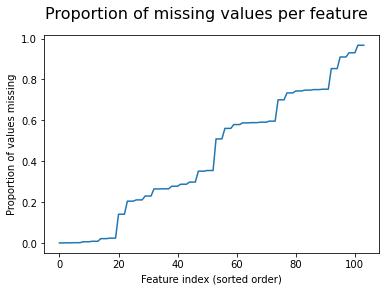

In [179]:
# Compute proportion of missing values
tot_rows = feature_set.shape[0]
prop_missing_vals = {}
missing_values = 0


for col_name in feature_set.columns:
    missing_vals = np.sum(feature_set.loc[:, col_name].isna())
    missing_values = missing_values + missing_vals
    prop_missing_vals[col_name] = missing_vals / tot_rows

    #if prop_missing_vals[col_name] > 0.8:
    #    X.drop(col_name, inplace=True, axis=1)
#print(missing_values)
def sort_dict(d: dict) -> dict:
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
    
prop_missing_vals = sort_dict(prop_missing_vals)
#print(prop_missing_vals)

props = list(prop_missing_vals.values())
plt.plot(props)
plt.suptitle("Proportion of missing values per feature", size=16)
plt.xlabel("Feature index (sorted order)")
plt.ylabel("Proportion of values missing")